# Strategy 2: Short Covering Rally Fade

## Concept
Fade rallies that are driven by short covering (not new longs) — these tend to be unsustainable.

## Strategy Rules
- **Short Entry:** Price rises > 3% over 5 days + OI decreases > 3% over same period + Volume elevated (> 1.2x average) + RSI(14) > 70
- **Exit:** Price returns to 10-day SMA OR OI starts rising again
- **Stop Loss:** New 20-day high

## Rationale
Rising price + falling OI = shorts exiting, not new buyers. Rally exhaustion is likely.

## Data
- Price: F1_RolledPrice (WTI CL continuous front-month)
- Volume: F1_Volume
- Open Interest: AGG_OI (aggregate across all contracts)

## Cell 1: Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# Strategy Parameters
PRICE_RISE_PERIOD = 5           # Days to measure price rise
PRICE_RISE_THRESHOLD = 0.03     # Price must rise > 3%
OI_DECLINE_PERIOD = 5           # Days to measure OI decline
OI_DECLINE_THRESHOLD = 0.03     # OI must decline > 3%
VOLUME_MULTIPLIER = 1.2         # Volume must be > 1.2x 20-day avg
RSI_PERIOD = 14                 # RSI calculation period
RSI_OVERBOUGHT = 70             # RSI threshold for overbought
SMA_EXIT_PERIOD = 10            # Exit when price returns to 10-day SMA
STOP_LOSS_LOOKBACK = 20         # Stop loss at 20-day high

# Cost assumptions
SLIPPAGE_AND_COMMISSION = 5     # $ per round-trip trade
POINT_VALUE = 1000              # WTI CL contract: $1000 per point

# Data paths
DATA_DIR = Path('../../cache/raw_data')

print("Configuration loaded successfully")
print(f"Strategy: Fade rallies with Price rise > {PRICE_RISE_THRESHOLD*100}% and OI decline > {OI_DECLINE_THRESHOLD*100}% over {PRICE_RISE_PERIOD} days")
print(f"Entry filter: Volume > {VOLUME_MULTIPLIER}x avg, RSI > {RSI_OVERBOUGHT}")
print(f"Exit: Price touches {SMA_EXIT_PERIOD}-day SMA or OI rises")

Configuration loaded successfully
Strategy: Fade rallies with Price rise > 3.0% and OI decline > 3.0% over 5 days
Entry filter: Volume > 1.2x avg, RSI > 70
Exit: Price touches 10-day SMA or OI rises


## Cell 2: Load Data

In [2]:
# Load data files
prices_df = pd.read_csv(DATA_DIR / 'prices_db.csv', index_col=0)
oi_df = pd.read_csv(DATA_DIR / 'openinterest_db.csv', index_col=0)
volume_df = pd.read_csv(DATA_DIR / 'volume_db.csv', index_col=0)

# Filter for CL (WTI) only
prices_df = prices_df[prices_df['Name'] == 'CL'].copy()
oi_df = oi_df[oi_df['Name'] == 'CL'].copy()
volume_df = volume_df[volume_df['Name'] == 'CL'].copy()

# Clean volume_df (has an extra header row)
volume_df = volume_df[volume_df['tradeDate'].notna() & (volume_df['tradeDate'] != '')].copy()

# Convert dates
prices_df['tradeDate'] = pd.to_datetime(prices_df['tradeDate'])
oi_df['tradeDate'] = pd.to_datetime(oi_df['tradeDate'])
volume_df['tradeDate'] = pd.to_datetime(volume_df['tradeDate'])

# Merge datasets
df = prices_df[['tradeDate', 'F1_RolledPrice']].merge(
    oi_df[['tradeDate', 'AGG_OI']], on='tradeDate', how='inner'
).merge(
    volume_df[['tradeDate', 'F1_Volume']], on='tradeDate', how='inner'
)

# Sort by date and reset index
df = df.sort_values('tradeDate').reset_index(drop=True)

# Convert to numeric
df['F1_RolledPrice'] = pd.to_numeric(df['F1_RolledPrice'], errors='coerce')
df['AGG_OI'] = pd.to_numeric(df['AGG_OI'], errors='coerce')
df['F1_Volume'] = pd.to_numeric(df['F1_Volume'], errors='coerce')

# Rename columns for clarity
df.columns = ['date', 'price', 'oi', 'volume']

# Drop any rows with missing values
df = df.dropna().reset_index(drop=True)

print(f"Data loaded: {len(df)} rows")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nData preview:")
df.head(10)

Data loaded: 3920 rows
Date range: 2010-01-04 00:00:00 to 2025-07-29 00:00:00

Data preview:


,date,price,oi,volume
0,2010-01-04,104.06,1241859.0,263542.0
1,2010-01-05,104.32,1231436.0,258887.0
2,2010-01-06,105.73,1264706.0,370059.0
3,2010-01-07,105.21,1277089.0,246632.0
4,2010-01-08,105.30,1289625.0,310377.0
5,2010-01-11,105.07,1294224.0,296304.0
6,2010-01-12,103.34,1300867.0,333866.0
7,2010-01-13,102.20,1316280.0,401627.0
8,2010-01-14,101.94,1347402.0,275404.0
9,2010-01-15,100.55,1330155.0,200555.0


## Cell 3: Feature Engineering

In [3]:
# Price change over N days
df['price_change_5d'] = df['price'].pct_change(periods=PRICE_RISE_PERIOD)

# OI change over N days
df['oi_change_5d'] = df['oi'].pct_change(periods=OI_DECLINE_PERIOD)

# 20-day average volume
df['volume_avg_20d'] = df['volume'].rolling(window=20).mean()

# RSI(14) calculation
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    
    # Use exponential moving average for smoother RSI
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = calculate_rsi(df['price'], RSI_PERIOD)

# 10-day SMA for exit
df['sma_10'] = df['price'].rolling(window=SMA_EXIT_PERIOD).mean()

# 20-day high for stop loss
df['high_20d'] = df['price'].rolling(window=STOP_LOSS_LOOKBACK).max()

# Daily OI change (for exit condition - OI rising)
df['oi_daily_change'] = df['oi'].pct_change()

print("Features created:")
print(f"  - price_change_5d: {PRICE_RISE_PERIOD}-day price % change")
print(f"  - oi_change_5d: {OI_DECLINE_PERIOD}-day OI % change")
print(f"  - volume_avg_20d: 20-day average volume")
print(f"  - rsi: {RSI_PERIOD}-day RSI")
print(f"  - sma_10: {SMA_EXIT_PERIOD}-day SMA")
print(f"  - high_20d: {STOP_LOSS_LOOKBACK}-day high (for stop loss)")
print(f"\nFeature preview:")
df[['date', 'price', 'price_change_5d', 'oi_change_5d', 'rsi', 'sma_10', 'high_20d']].tail(15)

Features created:
  - price_change_5d: 5-day price % change
  - oi_change_5d: 5-day OI % change
  - volume_avg_20d: 20-day average volume
  - rsi: 14-day RSI
  - sma_10: 10-day SMA
  - high_20d: 20-day high (for stop loss)

Feature preview:


,date,price,price_change_5d,oi_change_5d,rsi,sma_10,high_20d
3905,2025-07-09,67.09,0.045667,0.019459,60.193155,65.243,72.55
3906,2025-07-10,65.28,-0.013301,0.017566,46.495874,65.408,72.55
3907,2025-07-11,67.16,0.022067,0.038609,57.960751,65.729,72.55
3908,2025-07-14,65.69,-0.014256,0.047203,48.570774,65.875,72.55
3909,2025-07-15,65.23,-0.026999,0.039109,45.886634,66.016,72.55
3910,2025-07-16,65.09,-0.029811,0.026975,45.013086,66.109,72.55
3911,2025-07-17,66.25,0.014859,0.007474,53.479888,66.118,72.55
3912,2025-07-18,66.05,-0.016528,-0.008413,51.890365,66.152,72.55
3913,2025-07-21,65.95,0.003958,-0.030320,51.015589,66.083,67.22
3914,2025-07-22,65.31,0.001226,-0.026966,45.367714,65.910,67.16


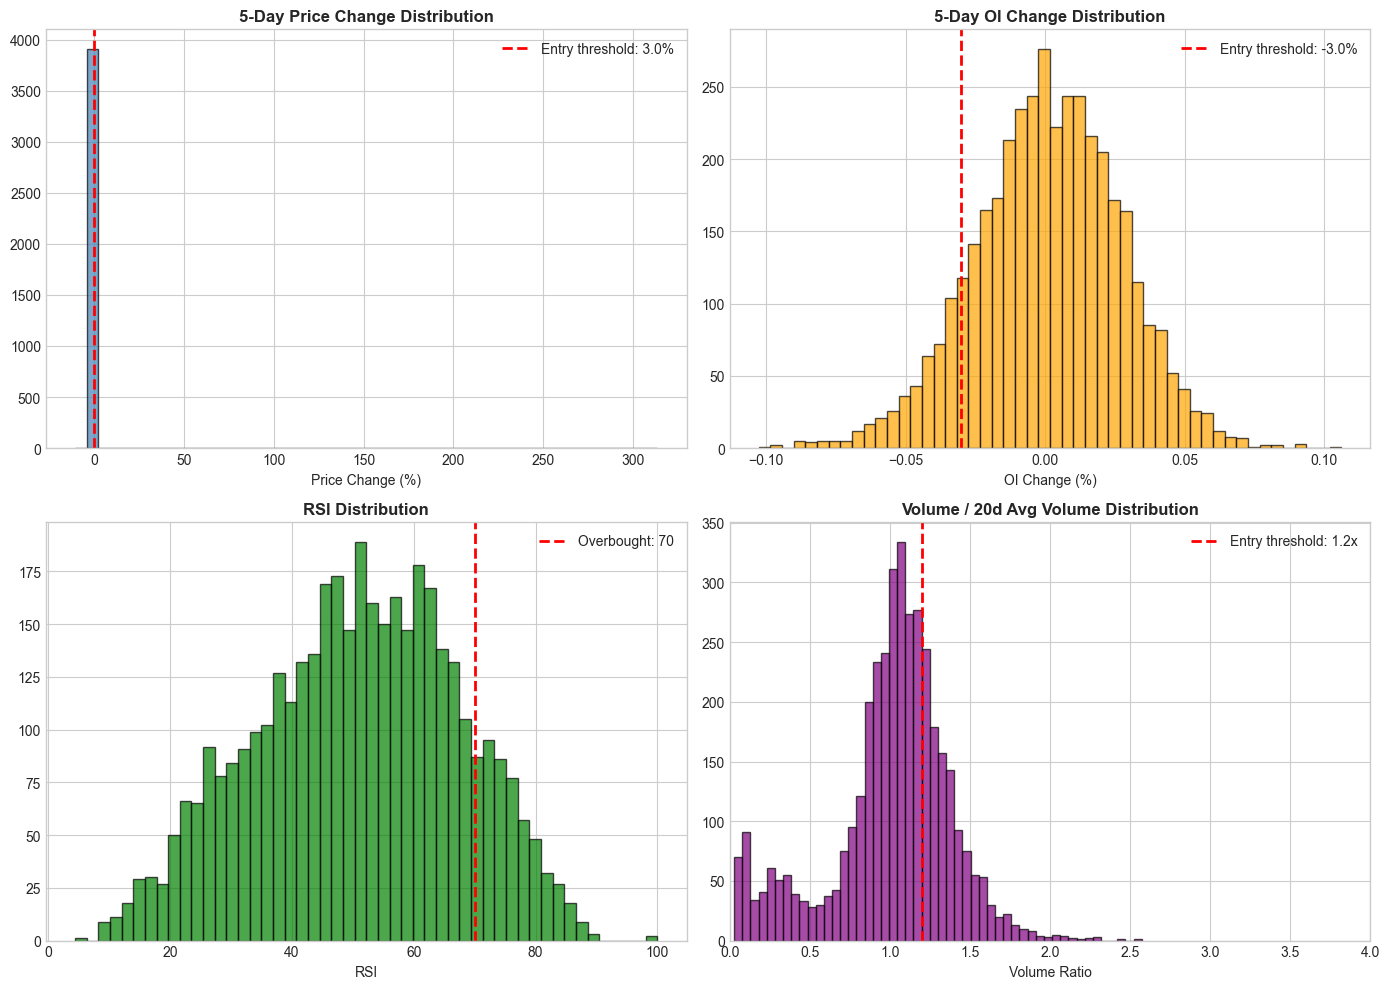


Signal component counts:
  Days with price rise > 3.0%: 1069
  Days with OI decline > 3.0%: 465
  Days with RSI > 70: 509
  Days with volume > 1.2x avg: 1127


In [4]:
# Distribution of key indicators
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 5-day price change distribution
ax1 = axes[0, 0]
df['price_change_5d'].dropna().hist(bins=50, ax=ax1, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(x=PRICE_RISE_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Entry threshold: {PRICE_RISE_THRESHOLD*100}%')
ax1.set_title('5-Day Price Change Distribution', fontweight='bold')
ax1.set_xlabel('Price Change (%)')
ax1.legend()

# 5-day OI change distribution
ax2 = axes[0, 1]
df['oi_change_5d'].dropna().hist(bins=50, ax=ax2, color='orange', edgecolor='black', alpha=0.7)
ax2.axvline(x=-OI_DECLINE_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Entry threshold: -{OI_DECLINE_THRESHOLD*100}%')
ax2.set_title('5-Day OI Change Distribution', fontweight='bold')
ax2.set_xlabel('OI Change (%)')
ax2.legend()

# RSI distribution
ax3 = axes[1, 0]
df['rsi'].dropna().hist(bins=50, ax=ax3, color='green', edgecolor='black', alpha=0.7)
ax3.axvline(x=RSI_OVERBOUGHT, color='red', linestyle='--', linewidth=2, label=f'Overbought: {RSI_OVERBOUGHT}')
ax3.set_title('RSI Distribution', fontweight='bold')
ax3.set_xlabel('RSI')
ax3.legend()

# Volume ratio distribution
ax4 = axes[1, 1]
volume_ratio = df['volume'] / df['volume_avg_20d']
volume_ratio.dropna().hist(bins=50, ax=ax4, color='purple', edgecolor='black', alpha=0.7)
ax4.axvline(x=VOLUME_MULTIPLIER, color='red', linestyle='--', linewidth=2, label=f'Entry threshold: {VOLUME_MULTIPLIER}x')
ax4.set_title('Volume / 20d Avg Volume Distribution', fontweight='bold')
ax4.set_xlabel('Volume Ratio')
ax4.set_xlim(0, 4)
ax4.legend()

plt.tight_layout()
plt.show()

# Count potential signals
print("\nSignal component counts:")
print(f"  Days with price rise > {PRICE_RISE_THRESHOLD*100}%: {(df['price_change_5d'] > PRICE_RISE_THRESHOLD).sum()}")
print(f"  Days with OI decline > {OI_DECLINE_THRESHOLD*100}%: {(df['oi_change_5d'] < -OI_DECLINE_THRESHOLD).sum()}")
print(f"  Days with RSI > {RSI_OVERBOUGHT}: {(df['rsi'] > RSI_OVERBOUGHT).sum()}")
print(f"  Days with volume > {VOLUME_MULTIPLIER}x avg: {(df['volume'] > VOLUME_MULTIPLIER * df['volume_avg_20d']).sum()}")

## Cell 4: Signal Generation

In [5]:
# Short entry conditions (fade the rally)
df['price_rallied'] = df['price_change_5d'] > PRICE_RISE_THRESHOLD
df['oi_declined'] = df['oi_change_5d'] < -OI_DECLINE_THRESHOLD
df['volume_elevated'] = df['volume'] > (VOLUME_MULTIPLIER * df['volume_avg_20d'])
df['rsi_overbought'] = df['rsi'] > RSI_OVERBOUGHT

# Combined short signal
df['short_signal'] = (df['price_rallied'] & 
                       df['oi_declined'] & 
                       df['volume_elevated'] & 
                       df['rsi_overbought'])

print("Signal Statistics:")
print(f"  Total trading days: {len(df)}")
print(f"  Days with price rally > {PRICE_RISE_THRESHOLD*100}%: {df['price_rallied'].sum()}")
print(f"  Days with OI decline > {OI_DECLINE_THRESHOLD*100}%: {df['oi_declined'].sum()}")
print(f"  Days with volume > {VOLUME_MULTIPLIER}x avg: {df['volume_elevated'].sum()}")
print(f"  Days with RSI > {RSI_OVERBOUGHT}: {df['rsi_overbought'].sum()}")
print(f"\n  SHORT SIGNALS (all conditions): {df['short_signal'].sum()}")

Signal Statistics:
  Total trading days: 3920
  Days with price rally > 3.0%: 1069
  Days with OI decline > 3.0%: 465
  Days with volume > 1.2x avg: 1127
  Days with RSI > 70: 509

  SHORT SIGNALS (all conditions): 12


In [6]:
# Preview signals
print("\nShort signal days:")
short_signals = df[df['short_signal']][['date', 'price', 'price_change_5d', 'oi_change_5d', 'rsi', 'volume', 'volume_avg_20d', 'sma_10', 'high_20d']]
print(short_signals.to_string())


Short signal days:
           date  price  price_change_5d  oi_change_5d        rsi    volume  volume_avg_20d  sma_10  high_20d
456  2011-10-24  95.71         0.051643     -0.033080  71.372907  484139.0       306280.80  91.370     95.71
2617 2020-05-22   5.62         1.973545     -0.036363  76.978975  429036.0       338167.10   2.062      6.29
2976 2021-10-25  56.46         0.038058     -0.036310  79.750529  568725.0       435357.40  54.624     56.46
3064 2022-03-02  85.71         0.275257     -0.038458  87.555575  651853.0       459187.50  70.315     85.71
3065 2022-03-03  82.78         0.218787     -0.065678  76.466632  592031.0       465945.90  71.802     85.71
3067 2022-03-07  94.51         0.334322     -0.094651  85.415457  576022.0       475605.90  77.199     94.51
3068 2022-03-08  98.81         0.258406     -0.064828  87.608227  583106.0       479873.50  80.378     98.81
3413 2023-07-24  63.63         0.079389     -0.038674  74.176280  368285.0       298359.55  60.790     63.63

In [7]:
# If no signals, try relaxing criteria
if df['short_signal'].sum() < 5:
    print("\n" + "="*50)
    print("Few signals detected. Testing relaxed criteria...")
    print("="*50)
    
    # Test without RSI filter
    signals_no_rsi = (df['price_rallied'] & df['oi_declined'] & df['volume_elevated']).sum()
    print(f"\nWithout RSI filter: {signals_no_rsi} signals")
    
    # Test without volume filter
    signals_no_vol = (df['price_rallied'] & df['oi_declined'] & df['rsi_overbought']).sum()
    print(f"Without volume filter: {signals_no_vol} signals")
    
    # Test with just price rally + OI decline
    signals_core = (df['price_rallied'] & df['oi_declined']).sum()
    print(f"Just price rally + OI decline: {signals_core} signals")
    
    # Test with relaxed thresholds
    relaxed_price = df['price_change_5d'] > 0.02  # 2% instead of 3%
    relaxed_oi = df['oi_change_5d'] < -0.02      # 2% instead of 3%
    relaxed_rsi = df['rsi'] > 65                  # 65 instead of 70
    relaxed_vol = df['volume'] > (1.0 * df['volume_avg_20d'])  # 1.0x instead of 1.2x
    
    signals_relaxed = (relaxed_price & relaxed_oi & relaxed_vol & relaxed_rsi).sum()
    print(f"\nRelaxed thresholds (2%/2%/65 RSI/1.0x vol): {signals_relaxed} signals")
    
    # Apply relaxed criteria if needed
    if signals_relaxed > df['short_signal'].sum():
        print("\n>>> Using relaxed criteria for backtest <<<")
        df['short_signal'] = relaxed_price & relaxed_oi & relaxed_vol & relaxed_rsi
        PRICE_RISE_THRESHOLD_USED = 0.02
        OI_DECLINE_THRESHOLD_USED = 0.02
        RSI_OVERBOUGHT_USED = 65
        VOLUME_MULTIPLIER_USED = 1.0
    else:
        PRICE_RISE_THRESHOLD_USED = PRICE_RISE_THRESHOLD
        OI_DECLINE_THRESHOLD_USED = OI_DECLINE_THRESHOLD
        RSI_OVERBOUGHT_USED = RSI_OVERBOUGHT
        VOLUME_MULTIPLIER_USED = VOLUME_MULTIPLIER
else:
    PRICE_RISE_THRESHOLD_USED = PRICE_RISE_THRESHOLD
    OI_DECLINE_THRESHOLD_USED = OI_DECLINE_THRESHOLD
    RSI_OVERBOUGHT_USED = RSI_OVERBOUGHT
    VOLUME_MULTIPLIER_USED = VOLUME_MULTIPLIER

print(f"\nFinal signal count: {df['short_signal'].sum()}")


Final signal count: 12


## Cell 5: Backtest Engine

In [8]:
def run_backtest(df, params):
    """
    Run backtest for short covering fade strategy.
    
    Entry: Short signal
    Exit: Price touches SMA OR OI starts rising OR Stop loss (20-day high)
    """
    trades = []
    position = 0  # 0 = flat, -1 = short
    entry_price = 0
    entry_date = None
    stop_loss = 0
    
    # Drop rows with NaN in required columns
    required_cols = ['sma_10', 'high_20d', 'oi_daily_change', 'short_signal']
    df_bt = df.dropna(subset=required_cols).copy()
    df_bt = df_bt.reset_index(drop=True)
    
    for i in range(len(df_bt)):
        row = df_bt.iloc[i]
        price = row['price']
        date = row['date']
        sma_10 = row['sma_10']
        oi_daily_change = row['oi_daily_change']
        
        # If in a short position, check exit conditions
        if position == -1:
            exit_reason = None
            
            # Update stop loss to current 20-day high (trailing stop for shorts)
            current_high_20d = row['high_20d']
            
            # Check stop loss (price >= 20-day high at entry)
            if price >= stop_loss:
                exit_reason = 'stop_loss'
            # Check if price returned to 10-day SMA (target exit)
            elif price <= sma_10:
                exit_reason = 'sma_target'
            # Check if OI starts rising (invalidates thesis)
            elif oi_daily_change > 0.01:  # OI rose by more than 1%
                exit_reason = 'oi_rising'
            
            # Execute exit
            if exit_reason:
                pnl_points = entry_price - price  # Short: profit when price falls
                pnl_dollars = pnl_points * params['point_value'] - params['costs']
                
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': date,
                    'direction': 'short',
                    'entry_price': entry_price,
                    'exit_price': price,
                    'stop_loss': stop_loss,
                    'pnl_points': pnl_points,
                    'pnl_dollars': pnl_dollars,
                    'exit_reason': exit_reason,
                    'holding_days': (date - entry_date).days
                })
                
                # Reset position
                position = 0
                entry_price = 0
                entry_date = None
                stop_loss = 0
        
        # If flat, check for entry signals
        if position == 0:
            if row['short_signal']:
                position = -1
                entry_price = price
                entry_date = date
                stop_loss = row['high_20d']  # Stop at 20-day high
    
    # Close any open position at the end
    if position == -1:
        final_price = df_bt.iloc[-1]['price']
        final_date = df_bt.iloc[-1]['date']
        pnl_points = entry_price - final_price
        pnl_dollars = pnl_points * params['point_value'] - params['costs']
        
        trades.append({
            'entry_date': entry_date,
            'exit_date': final_date,
            'direction': 'short',
            'entry_price': entry_price,
            'exit_price': final_price,
            'stop_loss': stop_loss,
            'pnl_points': pnl_points,
            'pnl_dollars': pnl_dollars,
            'exit_reason': 'end_of_data',
            'holding_days': (final_date - entry_date).days
        })
    
    return pd.DataFrame(trades)

# Run backtest
params = {
    'point_value': POINT_VALUE,
    'costs': SLIPPAGE_AND_COMMISSION
}

trades_df = run_backtest(df, params)
print(f"Backtest completed: {len(trades_df)} trades")
if len(trades_df) > 0:
    print("\nTrade details:")
    print(trades_df.to_string())

Backtest completed: 10 trades

Trade details:
  entry_date  exit_date direction  entry_price  exit_price  stop_loss  pnl_points  pnl_dollars exit_reason  holding_days
0 2011-10-24 2011-10-25     short        95.71       97.61      95.71       -1.90      -1905.0   stop_loss             1
1 2020-05-22 2020-05-26     short         5.62        6.72       6.29       -1.10      -1105.0   stop_loss             4
2 2021-10-25 2021-10-26     short        56.46       57.35      56.46       -0.89       -895.0   stop_loss             1
3 2022-03-02 2022-03-04     short        85.71       90.79      85.71       -5.08      -5085.0   stop_loss             2
4 2022-03-07 2022-03-08     short        94.51       98.81      94.51       -4.30      -4305.0   stop_loss             1
5 2022-03-08 2022-03-10     short        98.81       81.13      98.81       17.68      17675.0  sma_target             2
6 2023-07-24 2023-07-25     short        63.63       64.52      63.63       -0.89       -895.0   stop_loss 

## Cell 6: Performance Metrics

In [9]:
def calculate_metrics(trades_df, df, point_value=1000):
    """
    Calculate comprehensive performance metrics.
    """
    if len(trades_df) == 0:
        print("No trades to analyze")
        return None, None, None
    
    # Basic stats
    total_trades = len(trades_df)
    winning_trades = trades_df[trades_df['pnl_dollars'] > 0]
    losing_trades = trades_df[trades_df['pnl_dollars'] <= 0]
    
    win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
    
    # P&L metrics
    total_pnl = trades_df['pnl_dollars'].sum()
    avg_pnl = trades_df['pnl_dollars'].mean()
    avg_winner = winning_trades['pnl_dollars'].mean() if len(winning_trades) > 0 else 0
    avg_loser = losing_trades['pnl_dollars'].mean() if len(losing_trades) > 0 else 0
    
    # Profit factor
    gross_profit = winning_trades['pnl_dollars'].sum() if len(winning_trades) > 0 else 0
    gross_loss = abs(losing_trades['pnl_dollars'].sum()) if len(losing_trades) > 0 else 0
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    # Holding period
    avg_holding_days = trades_df['holding_days'].mean()
    
    # Calculate equity curve and drawdown
    trades_df_sorted = trades_df.sort_values('exit_date').copy()
    trades_df_sorted['cumulative_pnl'] = trades_df_sorted['pnl_dollars'].cumsum()
    trades_df_sorted['peak'] = trades_df_sorted['cumulative_pnl'].cummax()
    trades_df_sorted['drawdown'] = trades_df_sorted['cumulative_pnl'] - trades_df_sorted['peak']
    max_drawdown = trades_df_sorted['drawdown'].min()
    
    # Calculate date range for annualization
    start_date = df['date'].min()
    end_date = df['date'].max()
    years = (end_date - start_date).days / 365.25
    
    # Annualized return (assuming $100k initial capital)
    initial_capital = 100000
    final_equity = initial_capital + total_pnl
    cagr = (final_equity / initial_capital) ** (1/years) - 1 if years > 0 else 0
    
    # Sharpe ratio (simplified - using trade returns)
    if len(trades_df) > 1:
        returns_std = trades_df['pnl_dollars'].std()
        trades_per_year = total_trades / years
        sharpe = (avg_pnl * trades_per_year) / (returns_std * np.sqrt(trades_per_year)) if returns_std > 0 else 0
    else:
        sharpe = 0
    
    # Exit reason breakdown
    exit_reasons = trades_df['exit_reason'].value_counts().to_dict()
    
    metrics = {
        'Total Trades': total_trades,
        'Win Rate': f"{win_rate:.1%}",
        'Total P&L': f"${total_pnl:,.0f}",
        'Average P&L per Trade': f"${avg_pnl:,.0f}",
        'Average Winner': f"${avg_winner:,.0f}",
        'Average Loser': f"${avg_loser:,.0f}",
        'Profit Factor': f"{profit_factor:.2f}",
        'Max Drawdown': f"${max_drawdown:,.0f}",
        'CAGR': f"{cagr:.1%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Avg Holding Period': f"{avg_holding_days:.1f} days",
        'Test Period': f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}",
        'Years': f"{years:.1f}"
    }
    
    return metrics, trades_df_sorted, exit_reasons

# Calculate metrics
if len(trades_df) > 0:
    metrics, trades_with_equity, exit_reasons = calculate_metrics(trades_df, df, POINT_VALUE)
    
    if metrics:
        print("="*50)
        print("PERFORMANCE METRICS")
        print("="*50)
        for key, value in metrics.items():
            print(f"{key:25s}: {value}")
        
        print("\n" + "="*50)
        print("EXIT REASON BREAKDOWN")
        print("="*50)
        for reason, count in exit_reasons.items():
            print(f"{reason:20s}: {count} trades")
else:
    print("No trades were generated.")
    metrics = None
    trades_with_equity = None
    exit_reasons = None

PERFORMANCE METRICS
Total Trades             : 10
Win Rate                 : 20.0%
Total P&L                : $2,790
Average P&L per Trade    : $279
Average Winner           : $10,695
Average Loser            : $-2,325
Profit Factor            : 1.15
Max Drawdown             : $-11,390
CAGR                     : 0.2%
Sharpe Ratio             : 0.03
Avg Holding Period       : 2.3 days
Test Period              : 2010-01-04 to 2025-07-29
Years                    : 15.6

EXIT REASON BREAKDOWN
stop_loss           : 8 trades
sma_target          : 2 trades


## Cell 7: Visualizations

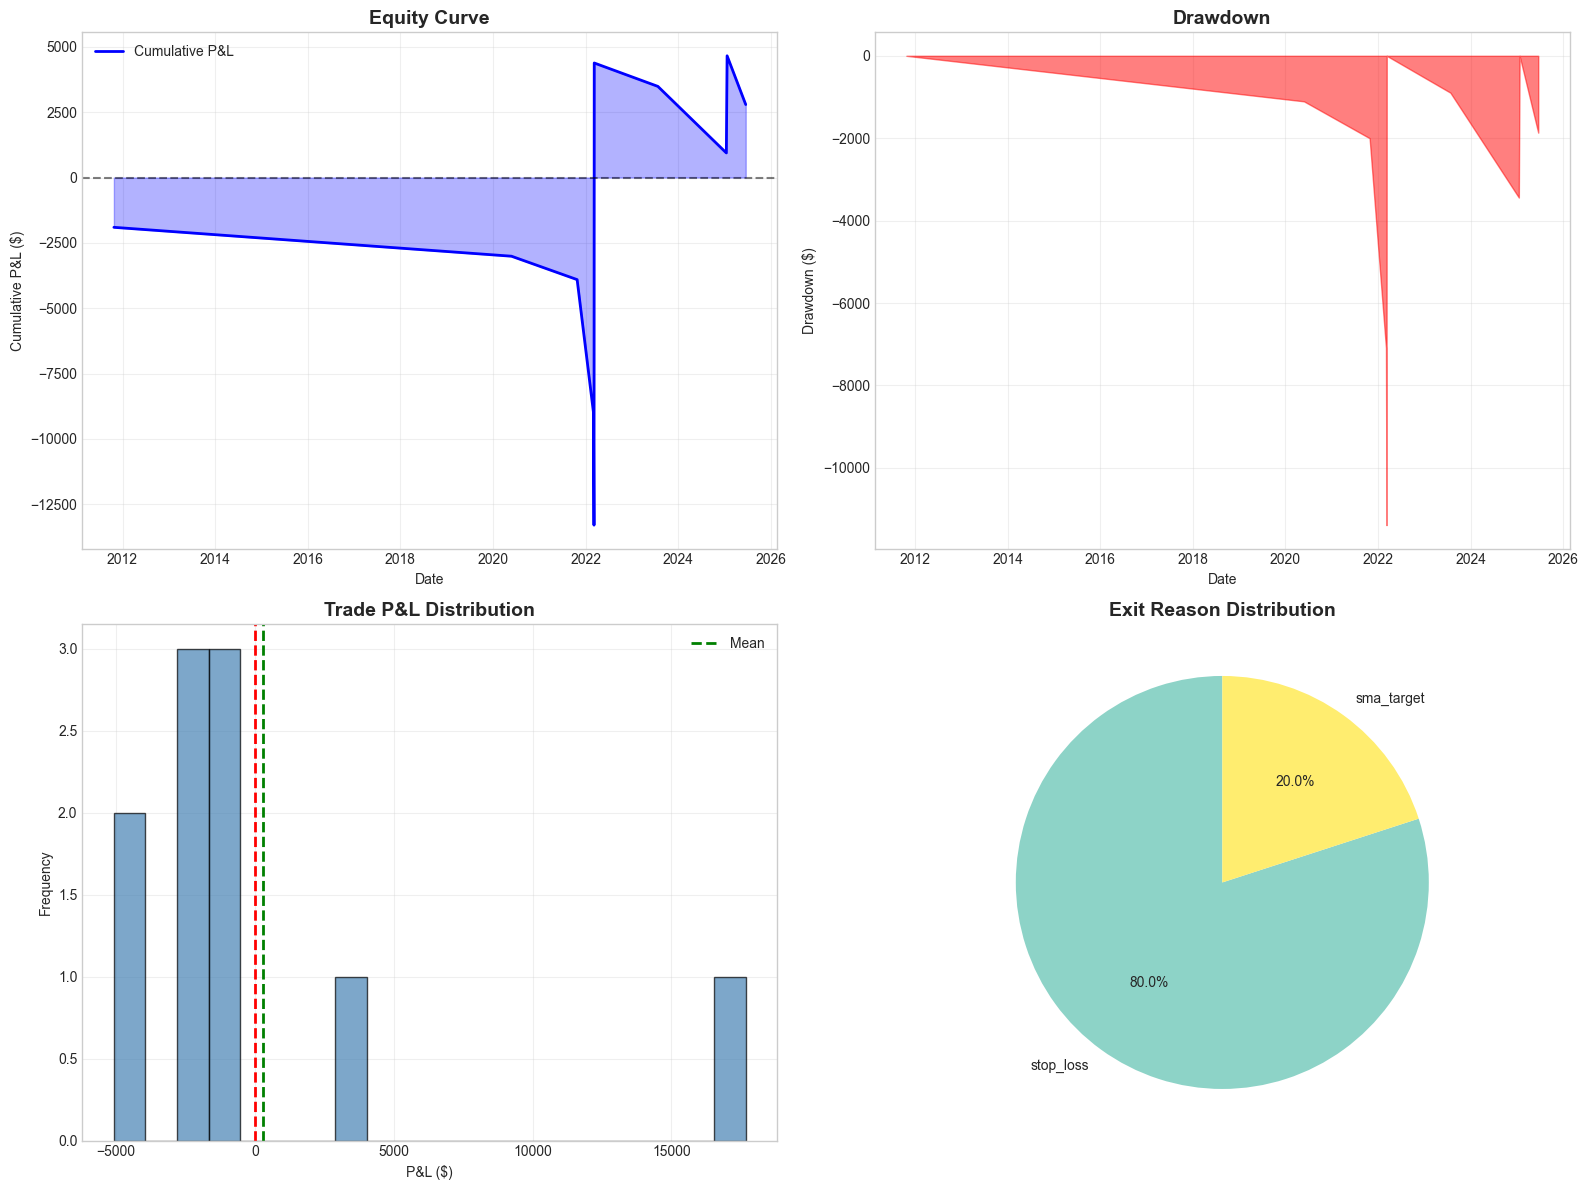

In [10]:
if len(trades_df) > 0 and trades_with_equity is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Equity Curve
    ax1 = axes[0, 0]
    ax1.plot(trades_with_equity['exit_date'], trades_with_equity['cumulative_pnl'], 
             linewidth=2, color='blue', label='Cumulative P&L')
    ax1.fill_between(trades_with_equity['exit_date'], 0, trades_with_equity['cumulative_pnl'],
                     alpha=0.3, color='blue')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_title('Equity Curve', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative P&L ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Drawdown
    ax2 = axes[0, 1]
    ax2.fill_between(trades_with_equity['exit_date'], 0, trades_with_equity['drawdown'],
                     color='red', alpha=0.5)
    ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown ($)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Trade P&L Distribution
    ax3 = axes[1, 0]
    ax3.hist(trades_df['pnl_dollars'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax3.axvline(x=trades_df['pnl_dollars'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')
    ax3.set_title('Trade P&L Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('P&L ($)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Exit Reason Pie Chart
    ax4 = axes[1, 1]
    exit_counts = trades_df['exit_reason'].value_counts()
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(exit_counts)))
    ax4.pie(exit_counts.values, labels=exit_counts.index, autopct='%1.1f%%', 
            colors=colors_pie, startangle=90)
    ax4.set_title('Exit Reason Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No trades to visualize.")

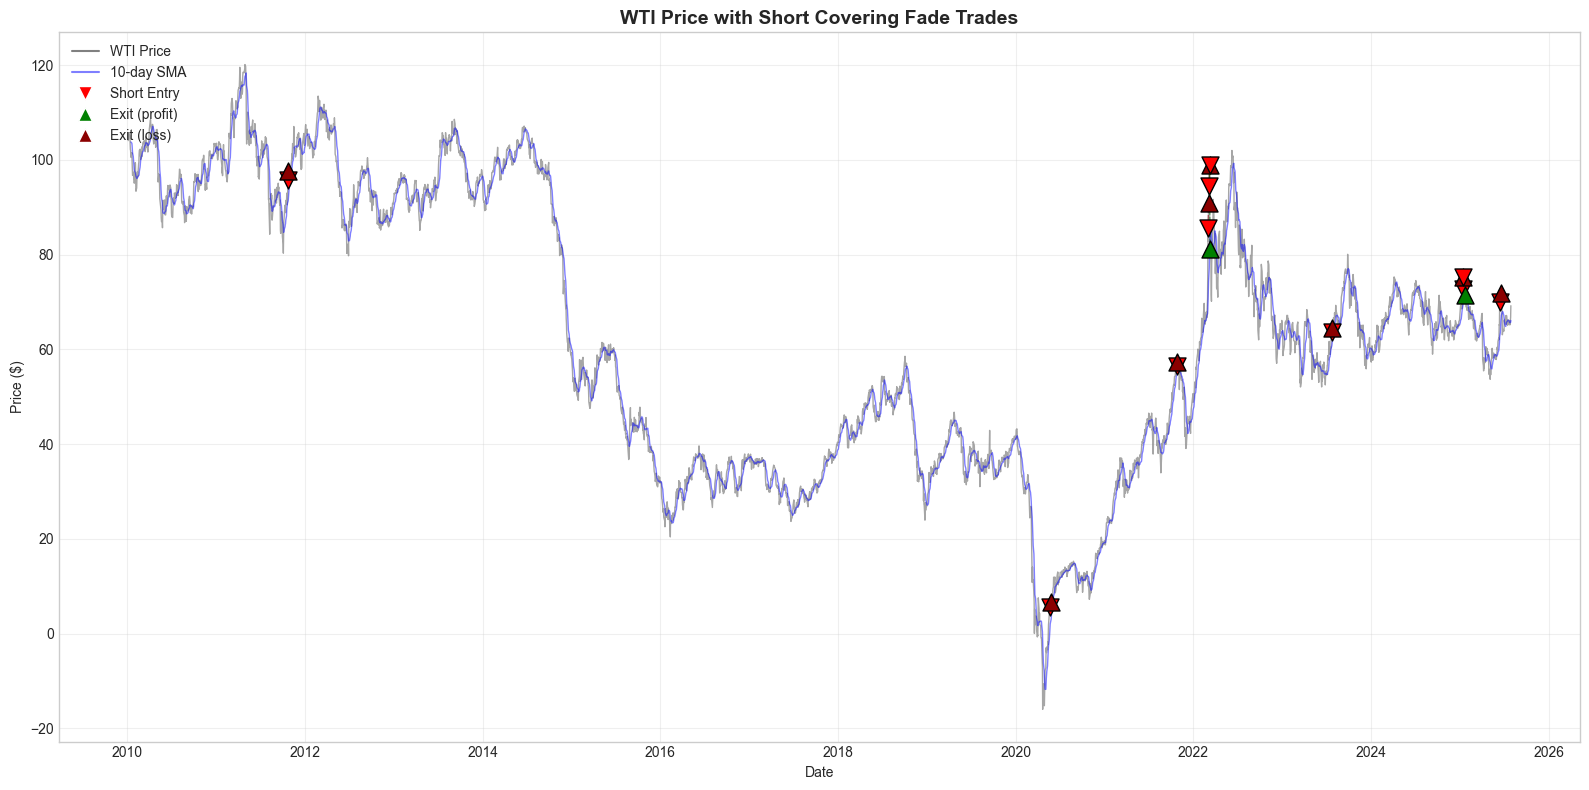

In [11]:
# Price chart with entry/exit points
if len(trades_df) > 0:
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot price
    ax.plot(df['date'], df['price'], linewidth=1, color='gray', alpha=0.7, label='WTI Price')
    
    # Plot 10-day SMA
    ax.plot(df['date'], df['sma_10'], linewidth=1, color='blue', alpha=0.5, label='10-day SMA')
    
    # Plot short entries/exits
    for _, trade in trades_df.iterrows():
        # Entry (short)
        ax.scatter(trade['entry_date'], trade['entry_price'], 
                   marker='v', color='red', s=150, zorder=5, edgecolors='black')
        # Exit
        exit_color = 'green' if trade['pnl_dollars'] > 0 else 'darkred'
        ax.scatter(trade['exit_date'], trade['exit_price'], 
                   marker='^', color=exit_color, s=150, zorder=5, edgecolors='black')
        
        # Draw line connecting entry and exit
        ax.plot([trade['entry_date'], trade['exit_date']], 
                [trade['entry_price'], trade['exit_price']],
                color=exit_color, linestyle='--', alpha=0.5, linewidth=1)
    
    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='gray', label='WTI Price'),
        Line2D([0], [0], color='blue', alpha=0.5, label='10-day SMA'),
        Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Short Entry'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Exit (profit)'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='darkred', markersize=10, label='Exit (loss)'),
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.set_title('WTI Price with Short Covering Fade Trades', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No trades to visualize.")


Yearly P&L Breakdown:
      Total P&L  Avg P&L  Trades
year                            
2011    -1905.0  -1905.0       1
2020    -1105.0  -1105.0       1
2021     -895.0   -895.0       1
2022     8285.0   2762.0       3
2023     -895.0   -895.0       1
2025     -695.0   -232.0       3


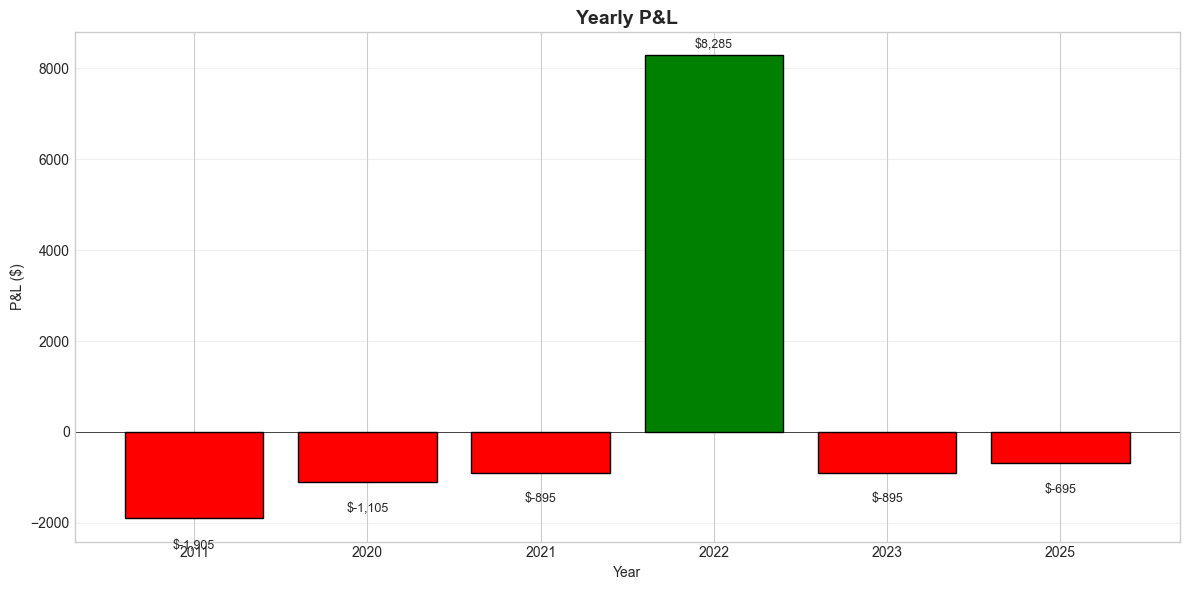

In [12]:
# Yearly P&L breakdown
if len(trades_df) > 0:
    trades_yearly = trades_df.copy()
    trades_yearly['year'] = trades_yearly['exit_date'].dt.year
    
    yearly_stats = trades_yearly.groupby('year').agg({
        'pnl_dollars': ['sum', 'mean', 'count'],
    }).round(0)
    yearly_stats.columns = ['Total P&L', 'Avg P&L', 'Trades']
    
    print("\nYearly P&L Breakdown:")
    print(yearly_stats.to_string())
    
    # Plot yearly P&L
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['green' if x > 0 else 'red' for x in yearly_stats['Total P&L']]
    bars = ax.bar(yearly_stats.index.astype(str), yearly_stats['Total P&L'], color=colors, edgecolor='black')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_title('Yearly P&L', fontsize=14, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('P&L ($)')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, yearly_stats['Total P&L']):
        height = bar.get_height()
        ax.annotate(f'${val:,.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=9)
    
    plt.tight_layout()
    plt.show()

## Cell 8: Summary & Observations

In [13]:
print("="*60)
print("STRATEGY 2: SHORT COVERING RALLY FADE - BACKTEST SUMMARY")
print("="*60)

print("\nStrategy Concept:")
print("  Fade rallies driven by short covering (rising price + falling OI)")
print("  These rallies tend to be unsustainable without new buying conviction.")

print("\nStrategy Parameters Used:")
try:
    print(f"  - Price rise threshold: {PRICE_RISE_THRESHOLD_USED*100}% over 5 days")
    print(f"  - OI decline threshold: {OI_DECLINE_THRESHOLD_USED*100}% over 5 days")
    print(f"  - Volume threshold: {VOLUME_MULTIPLIER_USED}x 20-day average")
    print(f"  - RSI overbought: > {RSI_OVERBOUGHT_USED}")
except:
    print(f"  - Price rise threshold: {PRICE_RISE_THRESHOLD*100}% over 5 days")
    print(f"  - OI decline threshold: {OI_DECLINE_THRESHOLD*100}% over 5 days")
    print(f"  - Volume threshold: {VOLUME_MULTIPLIER}x 20-day average")
    print(f"  - RSI overbought: > {RSI_OVERBOUGHT}")
print(f"  - Exit: Price touches 10-day SMA OR OI rises > 1% OR Stop loss at 20-day high")

if len(trades_df) > 0:
    print("\nKey Findings:")
    
    # Win rate analysis
    winners = len(trades_df[trades_df['pnl_dollars'] > 0])
    total = len(trades_df)
    win_rate = winners / total
    
    if win_rate >= 0.5:
        print(f"  + Win rate of {win_rate:.1%} indicates positive edge")
    else:
        print(f"  - Win rate of {win_rate:.1%} below 50%")
    
    # Profit factor
    gross_profit = trades_df[trades_df['pnl_dollars'] > 0]['pnl_dollars'].sum()
    gross_loss = abs(trades_df[trades_df['pnl_dollars'] <= 0]['pnl_dollars'].sum())
    pf = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    if pf > 1.5:
        print(f"  + Profit factor of {pf:.2f} is attractive (>1.5)")
    elif pf > 1:
        print(f"  ~ Profit factor of {pf:.2f} is marginally profitable")
    else:
        print(f"  - Profit factor of {pf:.2f} indicates unprofitable strategy")
    
    # Trade frequency
    years = (df['date'].max() - df['date'].min()).days / 365.25
    trades_per_year = len(trades_df) / years
    print(f"  ~ Trade frequency: {trades_per_year:.1f} trades/year")
    
    # Exit analysis
    print("\nExit Analysis:")
    for reason in trades_df['exit_reason'].unique():
        subset = trades_df[trades_df['exit_reason'] == reason]
        avg_pnl = subset['pnl_dollars'].mean()
        print(f"  - {reason}: {len(subset)} trades, avg P&L ${avg_pnl:,.0f}")
    
    print("\nPotential Improvements to Test:")
    print("  1. Adjust price/OI thresholds")
    print("  2. Add trend filter (only fade rallies in downtrends)")
    print("  3. Use tighter stop loss (e.g., ATR-based instead of 20-day high)")
    print("  4. Scale into position on continued weakness")
    print("  5. Add time-based exit (max holding period)")
else:
    print("\nNo trades generated. Suggestions:")
    print("  1. Relax price rise threshold (try 2% instead of 3%)")
    print("  2. Relax OI decline threshold (try 2% instead of 3%)")
    print("  3. Lower RSI threshold (try 65 instead of 70)")
    print("  4. Remove volume filter entirely")

STRATEGY 2: SHORT COVERING RALLY FADE - BACKTEST SUMMARY

Strategy Concept:
  Fade rallies driven by short covering (rising price + falling OI)
  These rallies tend to be unsustainable without new buying conviction.

Strategy Parameters Used:
  - Price rise threshold: 3.0% over 5 days
  - OI decline threshold: 3.0% over 5 days
  - Volume threshold: 1.2x 20-day average
  - RSI overbought: > 70
  - Exit: Price touches 10-day SMA OR OI rises > 1% OR Stop loss at 20-day high

Key Findings:
  - Win rate of 20.0% below 50%
  ~ Profit factor of 1.15 is marginally profitable
  ~ Trade frequency: 0.6 trades/year

Exit Analysis:
  - stop_loss: 8 trades, avg P&L $-2,325
  - sma_target: 2 trades, avg P&L $10,695

Potential Improvements to Test:
  1. Adjust price/OI thresholds
  2. Add trend filter (only fade rallies in downtrends)
  3. Use tighter stop loss (e.g., ATR-based instead of 20-day high)
  4. Scale into position on continued weakness
  5. Add time-based exit (max holding period)
